In [1]:
import pandas as pd
import re

In [2]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
def clean_column_names(df):
    """
    Limpia y transforma los nombres de las columnas para hacerlos más adecuados para el entrenamiento de modelos.

    :param df: DataFrame de Pandas
    :return: DataFrame con nombres de columnas limpios
    """
    def clean_name(name):
        # Convertir a minúsculas
        name = name.lower()
        # Reemplazar espacios y guiones por "_"
        name = re.sub(r'[\s-]+', '_', name)
        # Eliminar caracteres especiales no alfanuméricos excepto "_"
        name = re.sub(r'[^a-z0-9_]', '', name)
        return name
    
    # Aplicar limpieza a los nombres de columnas
    df.columns = [clean_name(col) for col in df.columns]
    
    # Asegurar unicidad de nombres
    seen = set()
    new_columns = []
    for col in df.columns:
        new_col = col
        count = 1
        while new_col in seen:
            new_col = f"{col}_{count}"
            count += 1
        seen.add(new_col)
        new_columns.append(new_col)
    
    df.columns = new_columns
    return df

##### carga del dataset y preparación de los datos.  

In [4]:
excel_path = './datasource/sample-flats-madrid-synthetic-coords.csv'
df_flats = pd.read_csv(excel_path, sep=';')

In [5]:
drop_columns = ['Unnamed: 0', 'CODE', 'LOCATIONNAME']

In [6]:
df_flats.drop(columns=drop_columns, inplace = True)

In [7]:
df_flats['is_outlier_room'] = df_flats['ROOMNUMBER'].apply(lambda x: 1 if x > 6 else 0)
df_flats['is_outlier_bath'] = df_flats['BATHNUMBER'].apply(lambda x: 1 if x > 6 else 0)

#### 1. Modelo quitando outliers.  

##### 1.1 Quitamos los outliers del dataset

In [8]:
dflats_no_outliers = df_flats[(df_flats['is_outlier_room'] != 1) | (df_flats['is_outlier_bath'] != 1)].copy()

In [ ]:
dflats_no_outliers.shape

In [ ]:
df_flats.shape

In [9]:
# Quitamos las columnas de outliers.
cols_to_drop = ['is_outlier_room', 'is_outlier_bath']
dflats_no_outliers.drop(columns = cols_to_drop, inplace = True)

In [10]:
cols = dflats_no_outliers.columns
cols

Index(['barrio', 'distrito', 'PRICE', 'AREA', 'ROOMNUMBER', 'BATHNUMBER',
       'STATUS', 'STUDIO', 'ISPENTHOUSE', 'DUPLEX', 'SWIMMINGPOOL', 'ELEVATOR',
       'X', 'Y'],
      dtype='object')

##### 1.2 Hacemos encoding de las columnas categóricas.  
Este método parece no atentar contra XGBoost, lo aplicamos a ['barrio', 'distrito', 'STATUS']  

In [11]:
# usamos LabelEncoder por en vez de one hot encoding por el xgboost que vamos a utilizar.
from sklearn.preprocessing import LabelEncoder

In [12]:
dflats_no_outliers = clean_column_names(dflats_no_outliers)

In [13]:
categorical_columns = ['barrio', 'distrito', 'status']

encoders = {}

for col in categorical_columns:
    enc = LabelEncoder()
    dflats_no_outliers[col + '_encoded'] = enc.fit_transform(dflats_no_outliers[col])
    encoders[col] = enc  # Guardamos el encoder

In [ ]:
dflats_no_outliers

In [14]:
dflats_no_outliers.columns

Index(['barrio', 'distrito', 'price', 'area', 'roomnumber', 'bathnumber',
       'status', 'studio', 'ispenthouse', 'duplex', 'swimmingpool', 'elevator',
       'x', 'y', 'barrio_encoded', 'distrito_encoded', 'status_encoded'],
      dtype='object')

##### 1.3 Entrenamiento del modelo básico.

In [23]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

In [16]:
# definimos las columnas a utilizar en el entrenamiento y que serán dadas por pantalla desde streamlit (salvo el target)
# quito x e y (coordenadas)  para simplificar streamlit
cols_xgb = ['price', 'area', 'roomnumber', 'bathnumber', 
            'studio', 'ispenthouse', 'duplex', 'swimmingpool', 'elevator', 
            'barrio_encoded', 'distrito_encoded', 'status_encoded'
           ]

In [17]:
dfinal = dflats_no_outliers[cols_xgb].copy()

In [18]:
X = dfinal.drop(columns = 'price')
y = dfinal['price']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",  # Para regresión
    eval_metric="rmse"
)

In [21]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##### 1.4 Evaluación del modelo.  

RMSE, en las mismas unidades que la variable target.  

In [24]:
y_pred = model.predict(X_test)
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 513.6693


MAE, más robusto frente a valores atípicos (al haber eliminado outliers, no tiene mucho sentido)  

In [25]:
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

MAE: 101055.3750


R2 Score, cercano a 1 indica que el modelo explica bien la variabilidad de los datos.

In [26]:
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.7908


Importancia de las variables 

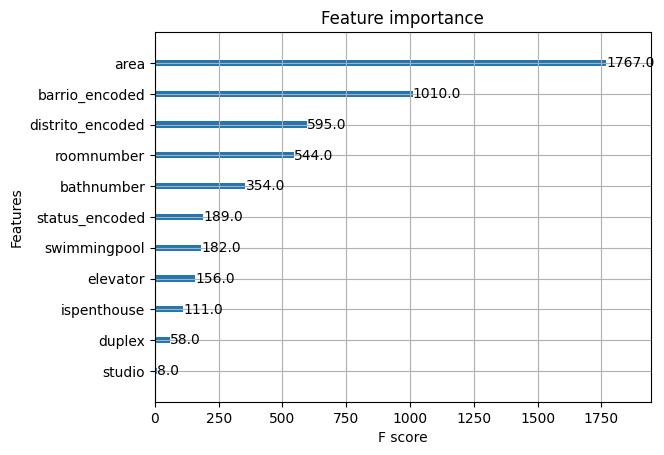

In [27]:
xgb.plot_importance(model)
plt.show()

##### 1.5 Mejora por selección de hiperparámetros (GridSearchCV).  

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

In [30]:
param_grid = {
    "n_estimators": [100, 200, 500],  
    "max_depth": [3, 5, 7],  
    "learning_rate": [0.01, 0.1, 0.3],  
    "subsample": [0.8, 1],  
    "colsample_bytree": [0.8, 1],  
    "alpha": [0, 0.1, 1],  
    "lambda": [1, 10]
}

In [31]:
grid_search = GridSearchCV(xgb_reg, param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 1], 'colsample_bytree': [0.8, 1],
                         'lambda': [1, 10], 'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.8, 1]},
             scoring='neg_mean_squared_error')

In [32]:
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'alpha': 0, 'colsample_bytree': 0.8, 'lambda': 10, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


##### 1.6 Modelado final con hiperparámetros propuestos.  

In [33]:
model_xgb_final = xgb.XGBRegressor(
    objective="reg:squarederror",  # Mantén el objetivo de regresión
    random_state=42,  # Opcional, para asegurar resultados reproducibles
    **grid_search.best_params_
)

In [34]:
model_xgb_final.fit(X_train, y_train)

XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=10, learning_rate=0.1,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [36]:
y_pred = model_xgb_final.predict(X_test)
rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 532.2620


In [37]:
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

R² Score: 0.7588


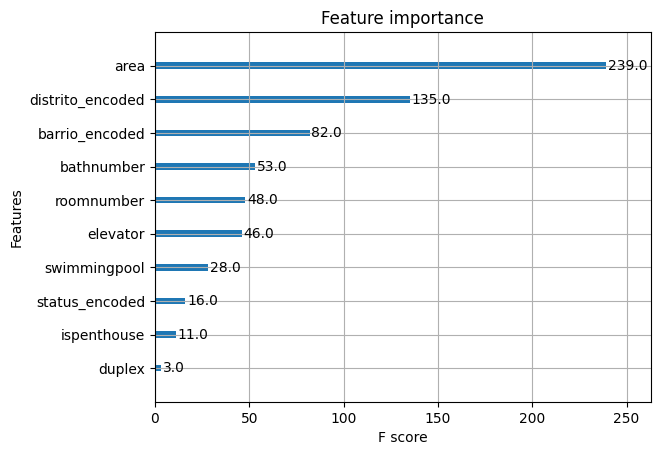

In [38]:
xgb.plot_importance(model_xgb_final)
plt.show()

##### 1.7 Guardamos el pickel del modelo y de los encoders utilizados 🥒🥒🥒  

In [39]:
import pickle

In [40]:
# Guardar los encoders en un archivo .pkl
with open('./model/encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

In [41]:
# Guardar el modelo entrenado con pickle
with open("./model/modelo_xgboost.pkl", 'wb') as model_file:
    pickle.dump(model_xgb_final, model_file)